# Logist Regression - One-vs-all multi-class classification (Classes Approach)
    
## Introduction

This notebook is a simple approach to the Sign Language Digits Dataset using Logistic Regression. The dataset consists of 2062 64x64 images of hand signs representing numbers from 0 to 9. The goal is to classify the images into the correct number using logistic regression. We will use the accuracy score as the metric to evaluate the model pair with the confusion matrix, F1 score, precision and recall. We will also test with PCA to see if it improves the model.



## Libraries

We will use the following libraries:

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import os
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import itertools
from skimage.transform import rotate, warp, AffineTransform
from skimage.util import random_noise
from skimage.exposure import adjust_gamma
import random
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from keras_tuner import RandomSearch
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

## Data Loading

Load the data, which consists of features (X) and labels (Y), from `.npy` files.

In [33]:
X_original = np.load('archive/X.npy')
Y_original = np.load('archive/Y.npy')

print(X_original.shape)
print(Y_original.shape)

(2062, 64, 64)
(2062, 10)


## Data Organization

Since the dataset is not properly organized, we will organize it by the digit they represent, i.e, we will start with the digit 0 and end with the digit 9.

In [34]:
def save_dataset_with_timestamp(X, Y, prefix='archive/X', suffix='archive/Y'):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    np.save(f'{prefix}_{timestamp}.npy', X)
    np.save(f'{suffix}_{timestamp}.npy', Y)

X = np.copy(X_original)
Y = np.copy(Y_original)

# Mapping classes to the correct digits
# class 0 = digit 9, class 1 = digit 0, class 2 = digit 7, class 3 = digit 6, class 4 = digit 1, class 5 = digit 8, class 6 = digit 4, class 7 = digit 3, class 8 = digit 2, class 9 = digit 5

class_to_digit = {0: 9, 1: 0, 2: 7, 3: 6, 4: 1, 5: 8, 6: 4, 7: 3, 8: 2, 9: 5}

# Convert Y from one-hot encoding to class indices
labels_indices = np.argmax(Y, axis=1)

# Correct the indices based on the mapping
correted_labels = np.array([class_to_digit[label] for label in labels_indices])

# Convert back to one-hot encoding
correted_Y = np.eye(10)[correted_labels]

print('Labels corrigidos: ', correted_labels[:2000])

# Sort the dataset by the digit each sample represents
sorted_indices = np.argsort(correted_labels)

print('Labels ordenados: ', correted_labels[sorted_indices])


# ordenar os labels
correted_Y = correted_Y[sorted_indices]
correted_X = X[sorted_indices]

# salvar os dados
save_dataset_with_timestamp(correted_X, correted_Y)

Labels corrigidos:  [9 9 9 ... 5 5 5]
Labels ordenados:  [0 0 0 ... 9 9 9]


## Data Splitting (Training, Validation and Testing)

We will split the data into training and testing sets using the `train_test_split` function from the `sklearn` library.

X_train shape: (1443, 4096)
Y_train shape: (1443, 1)
X_test shape: (309, 4096)
Y_test shape: (309, 1)
X_val shape: (310, 4096)
Y_val shape: (310, 1)


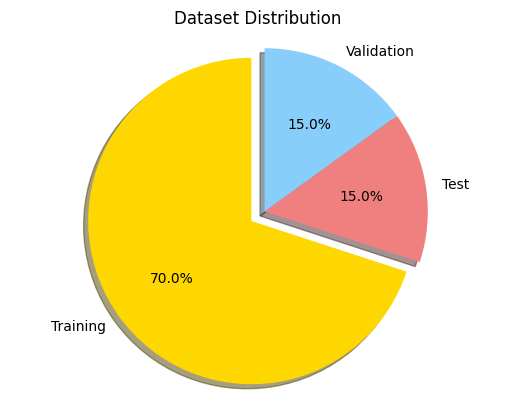

In [35]:
# # We are going to create a training,test and validation array, 70% - training, 15% - test, 15% - cross validation

#reshape Y
correted_Y = np.argmax(correted_Y, axis=1)
correted_Y = correted_Y.reshape(-1, 1)

# reshape dataset to 2D, removing the third dimension
X_flatten = correted_X.reshape(correted_X.shape[0], correted_X.shape[1] * correted_X.shape[2])

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, correted_Y, test_size=0.3, random_state=42)

# Split the test set into test and validation sets
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the shapes of the training, test and validation sets
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

train_percent = len(Y_train) / len(correted_Y)
test_percent = len(Y_test) / len(correted_Y)
val_percent = len(Y_val) / len(correted_Y)

# Plotting the pie chart
labels = 'Training', 'Test', 'Validation'
sizes = [train_percent, test_percent, val_percent]
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # only "explode" the 1st slice (training)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Dataset Distribution')
plt.show()

## Augmented Data Splitting


X_train_augmented shape: (18764, 4096)
Y_train_augmented shape: (18764, 1)
X_test_augmented shape: (4021, 4096)
Y_test_augmented shape: (4021, 1)
X_val_augmented shape: (4021, 4096)
Y_val_augmented shape: (4021, 1)


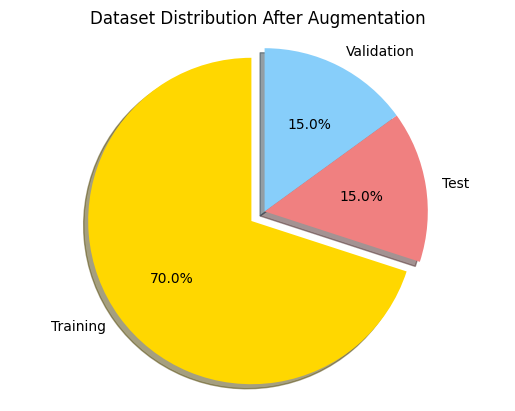

In [36]:
X_augmented = np.load('archive/Augmentation/X_augmented.npy')
Y_augmented = np.load('archive/Augmentation/Y_augmented.npy')

Y_augmented = np.argmax(Y_augmented, axis=1)

#reshape dataset to 2D, removing the third dimension
Y_augmented = Y_augmented.reshape(-1, 1)

X_augmented_flatten = X_augmented.reshape(X_augmented.shape[0], X_augmented.shape[1] * X_augmented.shape[2])

# Split the dataset into training and test sets
X_train_augmented, X_test_augmented, Y_train_augmented, Y_test_augmented = train_test_split(X_augmented_flatten, Y_augmented, test_size=0.3, random_state=42)

# Split the test set into test and validation sets
X_test_augmented, X_val_augmented, Y_test_augmented, Y_val_augmented = train_test_split(X_test_augmented, Y_test_augmented, test_size=0.5, random_state=42)

# Print the shapes of the training, test and validation sets
print(f'X_train_augmented shape: {X_train_augmented.shape}')
print(f'Y_train_augmented shape: {Y_train_augmented.shape}')

print(f'X_test_augmented shape: {X_test_augmented.shape}')
print(f'Y_test_augmented shape: {Y_test_augmented.shape}')

print(f'X_val_augmented shape: {X_val_augmented.shape}')
print(f'Y_val_augmented shape: {Y_val_augmented.shape}')

# Plotting the pie chart
train_percent = len(Y_train_augmented) / len(Y_augmented)
test_percent = len(Y_test_augmented) / len(Y_augmented)
val_percent = len(Y_val_augmented) / len(Y_augmented)

labels = 'Training', 'Test', 'Validation'
sizes = [train_percent, test_percent, val_percent]
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # only "explode" the 1st slice (training)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Dataset Distribution After Augmentation')
plt.show()

## Plot Comfusion Matrix

In [37]:
# Define train and analyse model functions
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, cross_validate


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Logist Regression - One-vs-all multi-class classification (Keras Approach)

## Model Training and Evaluation

In [9]:
def train_and_analyze_keras_not_tuned(X_train, y_train, X_test, y_test, X_val, y_val, num_classes):
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.fit_transform(y_test)
    y_val_encoded = encoder.fit_transform(y_val)
    
    y_train_encoded = np.eye(num_classes)[y_train_encoded]
    y_test_encoded = np.eye(num_classes)[y_test_encoded]
    y_val_encoded = np.eye(num_classes)[y_val_encoded]
    
    model = Sequential()
    model.add(Dense(units=num_classes, input_shape=(X_train.shape[1],), activation='softmax'))
    
    # optimizer
    sgd = SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    
    # Compilar o modelo
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treinar o modelo
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=800, batch_size=10, verbose=0) #change to 800 later
    
    # Avaliar o modelo
    loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
    print(f"Test Set Loss: {loss}, Test Set Accuracy: {accuracy}")
    
    # Plotar a evolução da função de custo e da acurácia
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Fazer previsões para análise adicional
    pred_train = np.argmax(model.predict(X_train), axis=-1)
    pred_test = np.argmax(model.predict(X_test), axis=-1)
    pred_val = np.argmax(model.predict(X_val), axis=-1)
    
    # Transformar previsões de volta para rótulos originais
    pred_train = encoder.inverse_transform(pred_train)
    pred_test = encoder.inverse_transform(pred_test)
    pred_val = encoder.inverse_transform(pred_val)
    
    # Metrics and Confusion Matrices
    for (preds, true, name) in [(pred_train, y_train, "Train"), (pred_test, y_test, "Test"), (pred_val, y_val, "Validation")]:
        print(f"\n---- {name} Set Analysis ----")
        accuracy = accuracy_score(true, preds)
        f1 = f1_score(true, preds, average='weighted')
        print(f"Accuracy: {accuracy}, F1 Score: {f1}")
        print("\nClassification Report:")
        print(classification_report(true, preds))
        
        # Confusion Matrix
        cm = confusion_matrix(true, preds)
        plot_confusion_matrix(cm, target_names=np.unique(y_train).astype(str), title=f'{name} Set Confusion Matrix', normalize=False)
            
    # Certifique-se de retornar ambos, model e encoder
    return model, encoder


#### Training Original Dataset

/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_

Test Set Loss: 27.328083038330078, Test Set Accuracy: 0.737864077091217


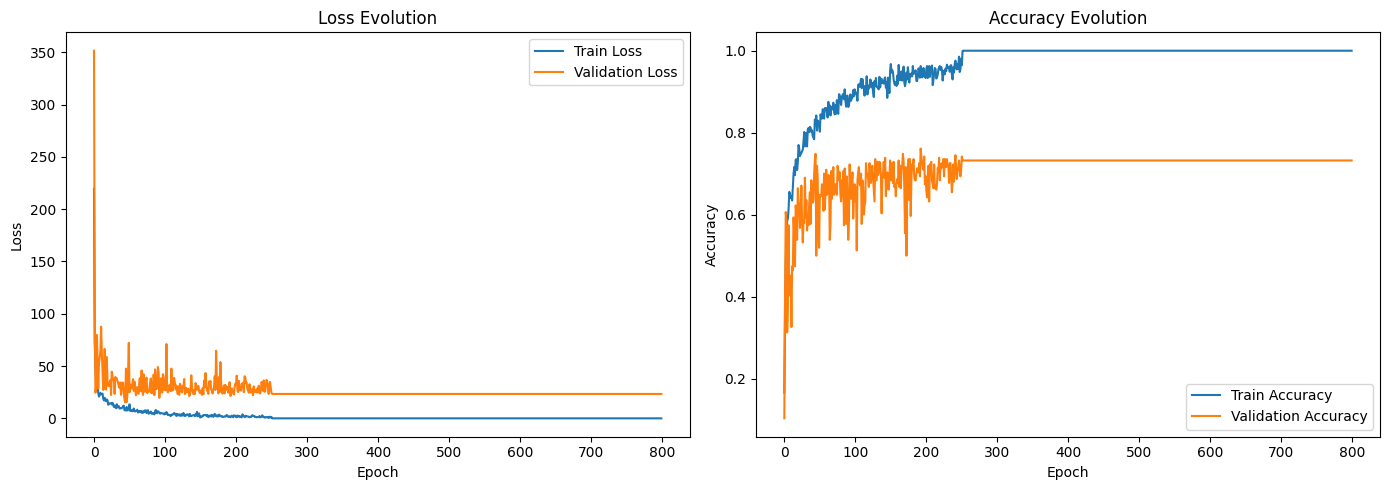

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step

---- Train Set Analysis ----
Accuracy: 1.0, F1 Score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       143
           4       1.00      1.00      1.00       155
           5       1.00      1.00      1.00       152
           6       1.00      1.00      1.00       142
           7       1.00      1.00      1.00       144
           8       1.00      1.00      1.00       146
           9       1.00      1.00      1.00       145

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443



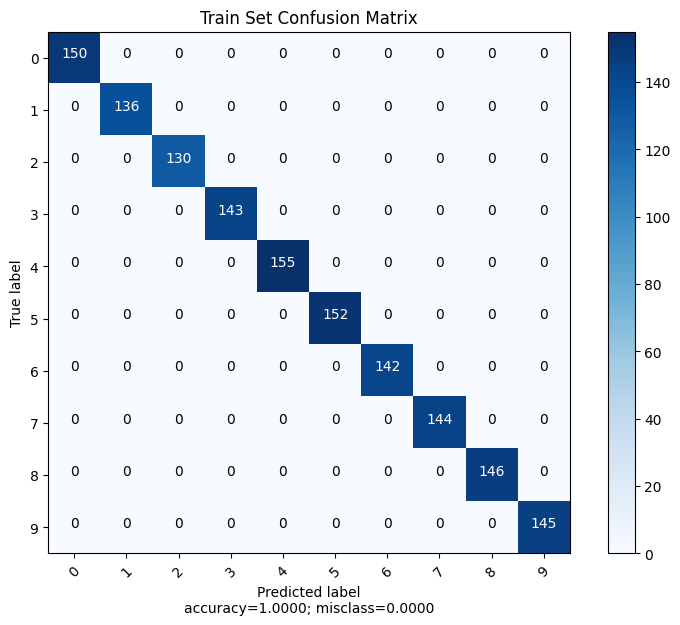


---- Test Set Analysis ----
Accuracy: 0.7378640776699029, F1 Score: 0.7363491232626245

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        27
           1       0.92      0.87      0.89        38
           2       0.67      0.57      0.62        35
           3       0.76      0.93      0.84        30
           4       0.67      0.69      0.68        32
           5       0.86      0.79      0.83        24
           6       0.63      0.65      0.64        34
           7       0.63      0.59      0.61        32
           8       0.70      0.75      0.72        28
           9       0.84      0.72      0.78        29

    accuracy                           0.74       309
   macro avg       0.74      0.74      0.74       309
weighted avg       0.74      0.74      0.74       309



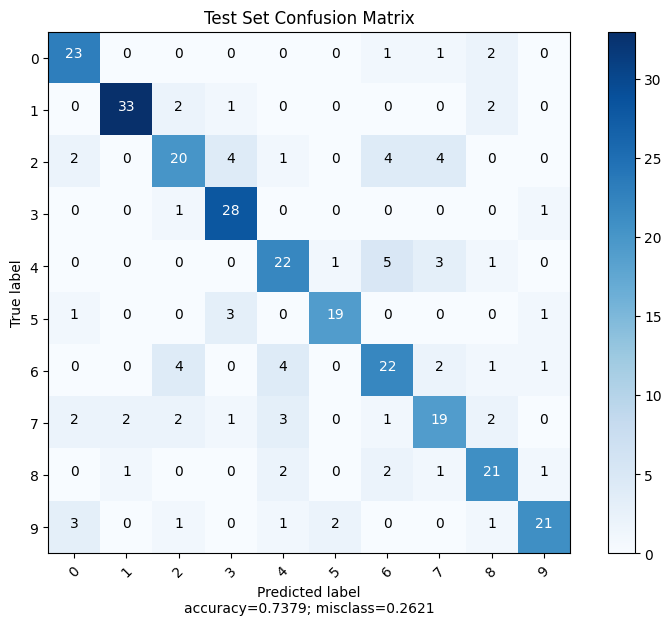


---- Validation Set Analysis ----
Accuracy: 0.7322580645161291, F1 Score: 0.729991516821806

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        28
           1       0.74      0.78      0.76        32
           2       0.81      0.51      0.63        41
           3       0.74      0.88      0.81        33
           4       0.53      0.50      0.51        20
           5       0.96      0.77      0.86        31
           6       0.72      0.68      0.70        31
           7       0.73      0.80      0.76        30
           8       0.68      0.68      0.68        34
           9       0.59      0.80      0.68        30

    accuracy                           0.73       310
   macro avg       0.74      0.73      0.73       310
weighted avg       0.74      0.73      0.73       310



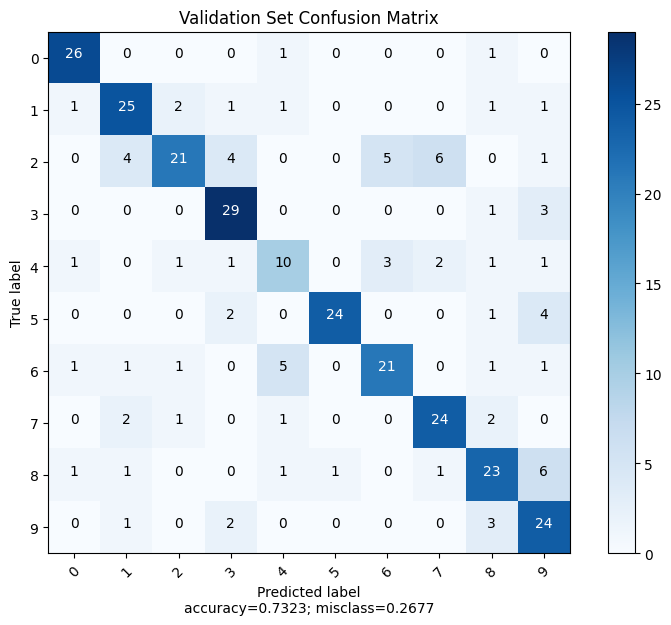

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

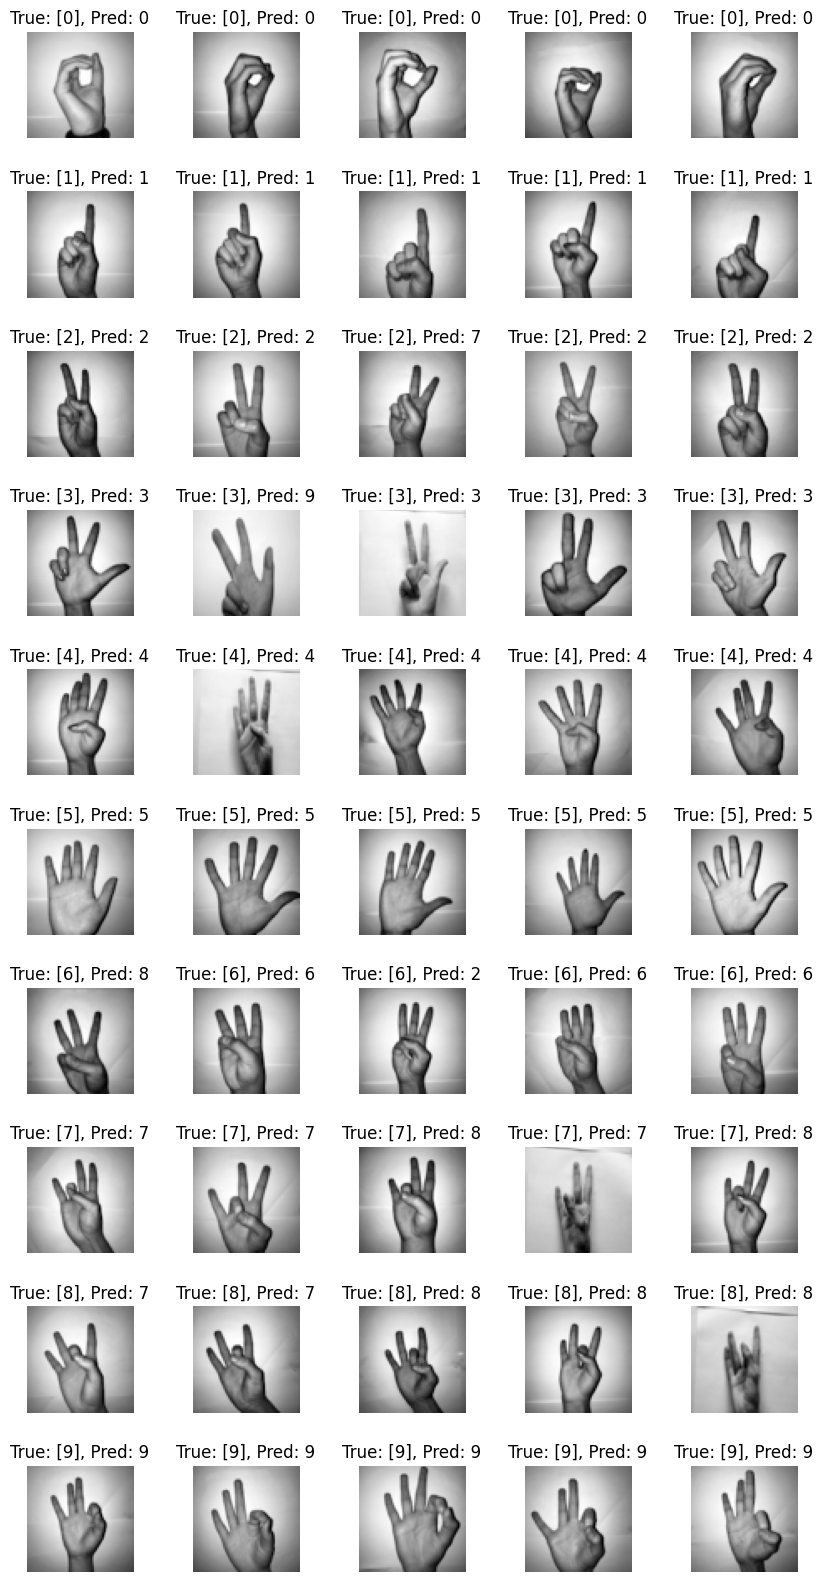

In [23]:
# Suponha que X_train, Y_train, X_test, Y_test, X_val, Y_val, X_original, e Y_original estão definidos corretamente
num_classes = 10  # Por exemplo, para um caso de classificação com 10 classes

# Train and analyze the model with Keras
trained_model, encoder = train_and_analyze_keras_not_tuned(X_train, Y_train, X_test, Y_test, X_val, Y_val, num_classes)

# Choose a random image to test the model
random_images = []

for i in range(10):  # Assumindo 10 classes
    random_images.append(np.where(correted_Y == i)[0][0:5])

random_images = np.array(random_images).flatten()

# Plot the images with predictions
fig, axes = plt.subplots(10, 5, figsize=(10, 20))  # Ajustar o tamanho conforme necessário

for idx, image_idx in enumerate(random_images):
    i, j = divmod(idx, 5)
    
    axes[i, j].imshow(correted_X[image_idx], cmap='gray')  # Ajuste aqui se X_original não é a variável correta
    axes[i, j].axis('off')
    
    # Preparar a imagem para predição (certifique-se de que está no formato correto esperado pelo modelo)
    image_prepared = X_flatten[image_idx].reshape(1, -1)  # Ajustar conforme o formato esperado pelo modelo
    
    # Fazer a predição
    pred_prob = trained_model.predict(image_prepared)
    pred_class = np.argmax(pred_prob, axis=-1)
    
    # Utilize o encoder para transformar a previsão de volta para o label original
    pred_label = encoder.inverse_transform(pred_class)[0]
    
    true_label = correted_Y[image_idx]
    axes[i, j].set_title(f'True: {true_label}, Pred: {pred_label}')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

## Hyperparameter Tuning

#### Construção do modelo com o dataset original

In [43]:
# def build_model(hp):
#     model = Sequential()
    
#     l2 = hp.Float('l2_regularization', min_value=1e-5, max_value=1e-2, sampling='log')

#     model.add(Dense(units=hp.Choice('units', [10, 20, 30, 40, 50]),
#                     activation='relu',
#                     input_shape=(X_train.shape[1],), #Dataset augmented
#                     kernel_regularizer=regularizers.l2(l2)))  # Aplicando regularização L2 corretamente
    
#     model.add(Dense(units=10,  # 'num_classes' deve ser definido fora desta função
#                     activation='softmax',
#                     kernel_regularizer=regularizers.l2(l2)))

#     # Permitindo que o Keras Tuner escolha o learning rate
#     learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
#     momentum = hp.Float('momentum', min_value=0.8, max_value=0.99, step=0.01)
#     nesterov = hp.Choice('nesterov', values=[True, False])
    
#     #regularization
    

#     model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

#### Construção do modelo com o dataset aumentado

In [47]:
def build_model(hp):
    model = Sequential()
    
    l2 = hp.Float('l2_regularization', min_value=1e-5, max_value=1e-2, sampling='log')

    model.add(Dense(units=hp.Choice('units', [10, 20, 30, 40, 50]),
                    activation='relu',
                    input_shape=(X_train_augmented.shape[1],), #Dataset augmented
                    kernel_regularizer=regularizers.l2(l2)))  # Aplicando regularização L2 corretamente
    
    model.add(Dense(units=10,  # 'num_classes' deve ser definido fora desta função
                    activation='softmax',
                    kernel_regularizer=regularizers.l2(l2)))

    # Permitindo que o Keras Tuner escolha o learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
    momentum = hp.Float('momentum', min_value=0.8, max_value=0.99, step=0.01)
    nesterov = hp.Choice('nesterov', values=[True, False])
    
    #regularization
    

    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def hyperparameter_tuning_test(X_train, y_train, X_val, y_val, X_test, y_test):
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_val_encoded = encoder.transform(y_val)
    y_test_encoded = encoder.transform(y_test)
    
    # One-hot encoding
    num_classes = len(np.unique(y_train_encoded))
    y_train_encoded = np.eye(num_classes)[y_train_encoded]
    y_val_encoded = np.eye(num_classes)[y_val_encoded]
    y_test_encoded = np.eye(num_classes)[y_test_encoded]

    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=20,  # Um valor intermediário, ajuste conforme sua capacidade computacional
        executions_per_trial=2,
        directory='tuning',
        project_name='keras_tuning_logistic'
    )

    tuner.search(X_train, y_train_encoded, epochs=800, validation_data=(X_val, y_val_encoded))

    # Obtendo os melhores hiperparâmetros
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print(f"""
    Otimização de Hiperparâmetros concluída. 
    - Número ótimo de unidades: {best_hps.get('units')}
    - Learning rate ótimo: {best_hps.get('learning_rate')}
    - Momentum ótimo: {best_hps.get('momentum')}
    - Nesterov ótimo: {best_hps.get('nesterov')}
    """)

    # Construindo e treinando o modelo com os melhores hiperparâmetros
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train_encoded, epochs=800, validation_data=(X_val, y_val_encoded))
    
    # Avaliar o modelo
    loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
    print(f"Test Set Loss: {loss},\n Test Set Accuracy: {accuracy}")
    
    # 
    
    # Plotar a evolução da função de custo e da acurácia
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Fazer previsões para análise adicional
    pred_train = np.argmax(model.predict(X_train), axis=-1)
    pred_test = np.argmax(model.predict(X_test), axis=-1)
    pred_val = np.argmax(model.predict(X_val), axis=-1)
    
    # Transformar previsões de volta para rótulos originais
    pred_train = encoder.inverse_transform(pred_train)
    pred_test = encoder.inverse_transform(pred_test)
    pred_val = encoder.inverse_transform(pred_val)
    
    # Metrics and Confusion Matrices
    for (preds, true, name) in [(pred_train, y_train, "Train"), (pred_test, y_test, "Test"), (pred_val, y_val, "Validation")]:
        print(f"\n---- {name} Set Analysis ----")
        accuracy = accuracy_score(true, preds)
        f1 = f1_score(true, preds, average='weighted')
        print(f"Accuracy: {accuracy}, F1 Score: {f1}")
        print("\nClassification Report:")
        print(classification_report(true, preds))
        
        # Confusion Matrix
        cm = confusion_matrix(true, preds)
        plot_confusion_matrix(cm, target_names=np.unique(y_train).astype(str), title=f'{name} Set Confusion Matrix', normalize=False)
            
    # Certifique-se de retornar ambos, model e encoder
    return model, encoder


## Train and Evaluate the model with the best hyperparameters

Reloading Tuner from tuning/keras_tuning_logistic/tuner0.json

    Otimização de Hiperparâmetros concluída. 
    - Número ótimo de unidades: 50
    - Learning rate ótimo: 0.0002631926470261117
    - Momentum ótimo: 0.8400000000000001
    - Nesterov ótimo: 1
    
Epoch 1/800


/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/keras/src/layers

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1102 - loss: 2.3373 - val_accuracy: 0.1290 - val_loss: 2.3130
Epoch 2/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1401 - loss: 2.2880 - val_accuracy: 0.1774 - val_loss: 2.2699
Epoch 3/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1756 - loss: 2.2583 - val_accuracy: 0.2129 - val_loss: 2.2477
Epoch 4/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1905 - loss: 2.2466 - val_accuracy: 0.2387 - val_loss: 2.2315
Epoch 5/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2696 - loss: 2.2150 - val_accuracy: 0.2000 - val_loss: 2.2167
Epoch 6/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2433 - loss: 2.2060 - val_accuracy: 0.2452 - val_loss: 2.1921
Epoch 7/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2779 - loss: 2.1766 - val_accuracy: 0.2355 - val_loss: 2.1791
Epoch 8/800
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2789 - loss: 2.1703 - val_accuracy: 0.2129 - val_loss: 2.1

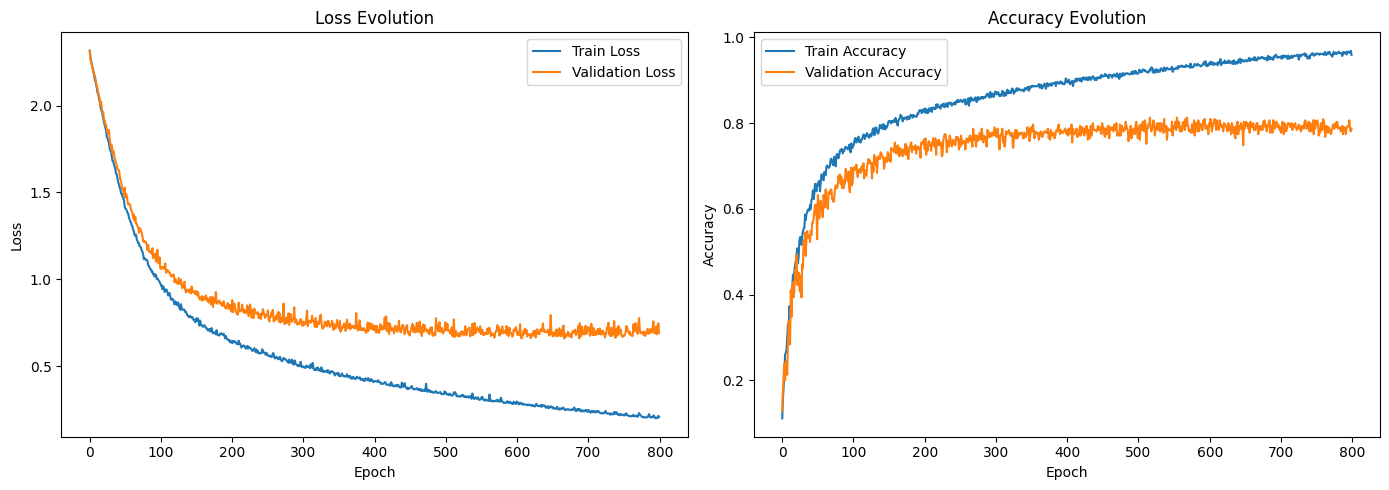

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step

---- Train Set Analysis ----
Accuracy: 0.9702009702009702, F1 Score: 0.970218494993006

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       150
           1       0.96      0.99      0.97       136
           2       0.98      0.98      0.98       130
           3       0.99      0.98      0.99       143
           4       0.94      0.96      0.95       155
           5       0.99      0.99      0.99       152
           6       0.95      0.94      0.94       142
           7       0.97      0.96      0.96       144
           8       0.96      0.97      0.96       146
           9       0.99      0.98      0.98       145

    accuracy                           0.97      1443
   macro avg       0.97      0.97      0.97      1443
weighted avg       0.97      0.97      0.97      1443



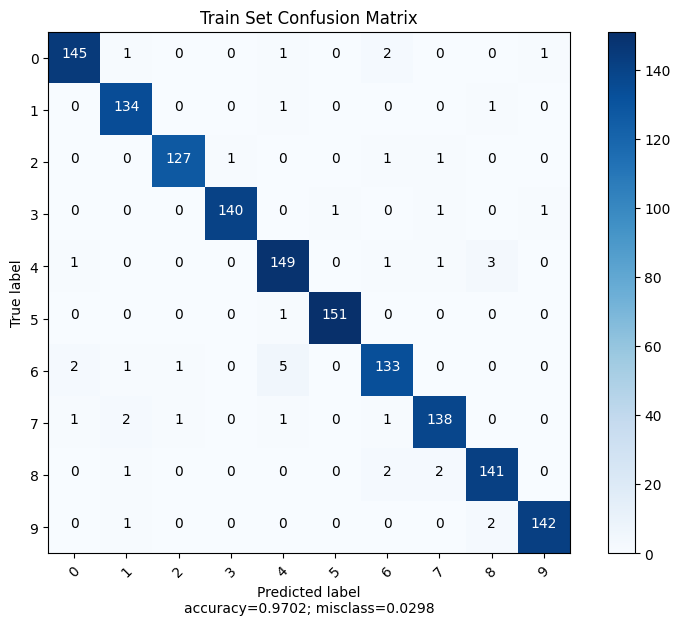


---- Test Set Analysis ----
Accuracy: 0.7864077669902912, F1 Score: 0.7865771187865922

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        27
           1       0.97      0.87      0.92        38
           2       0.79      0.74      0.76        35
           3       0.80      0.93      0.86        30
           4       0.71      0.78      0.75        32
           5       0.80      0.83      0.82        24
           6       0.74      0.74      0.74        34
           7       0.71      0.69      0.70        32
           8       0.69      0.71      0.70        28
           9       0.84      0.72      0.78        29

    accuracy                           0.79       309
   macro avg       0.79      0.79      0.79       309
weighted avg       0.79      0.79      0.79       309



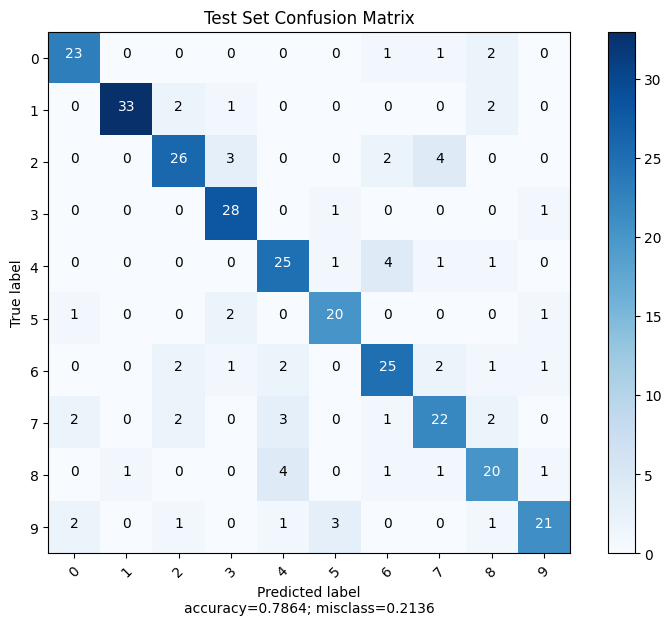


---- Validation Set Analysis ----
Accuracy: 0.7870967741935484, F1 Score: 0.7842294090618275

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.80      0.75      0.77        32
           2       0.77      0.56      0.65        41
           3       0.88      0.85      0.86        33
           4       0.57      0.65      0.60        20
           5       0.91      0.94      0.92        31
           6       0.81      0.81      0.81        31
           7       0.70      0.93      0.80        30
           8       0.82      0.68      0.74        34
           9       0.73      0.80      0.76        30

    accuracy                           0.79       310
   macro avg       0.78      0.79      0.78       310
weighted avg       0.79      0.79      0.78       310



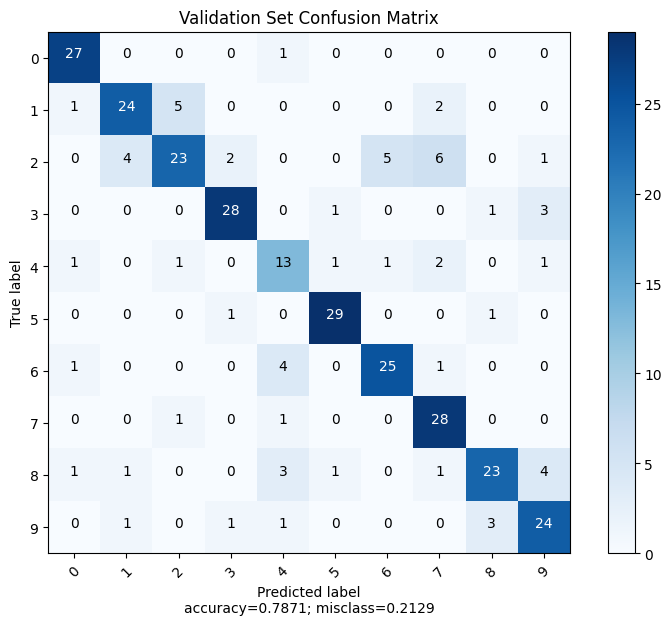

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━

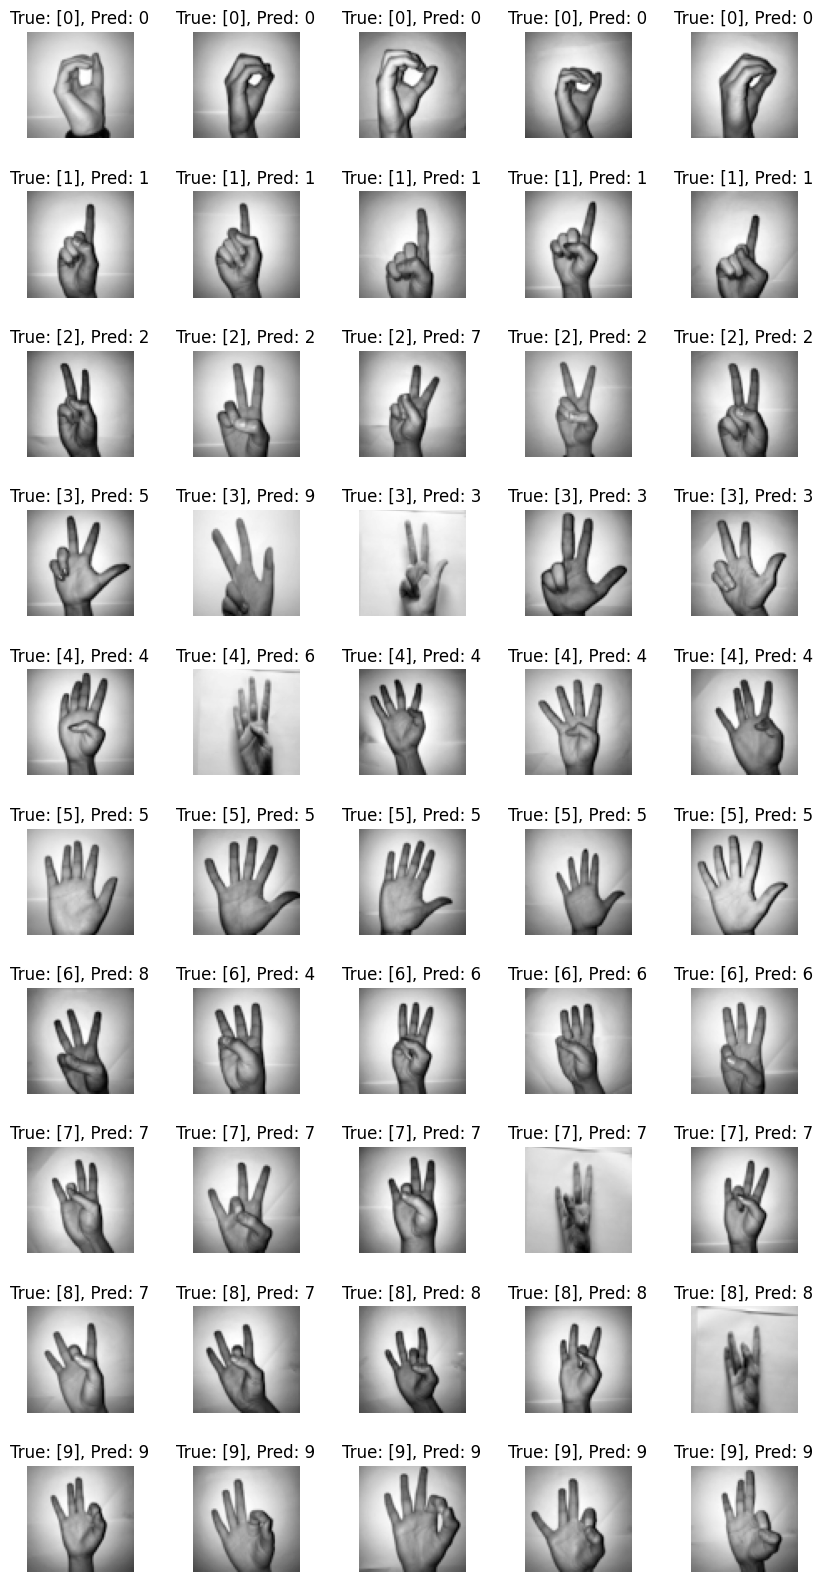

In [45]:
# Suponha que X_train, Y_train, X_test, Y_test, X_val, Y_val, X_original, e Y_original estão definidos corretamente
# Train and analyze the model with Keras
trained_model, encoder = hyperparameter_tuning_test(X_train, Y_train, X_val, Y_val, X_test, Y_test)

# Choose a random image to test the model
random_images = []

for i in range(10):  # Assumindo 10 classes
    random_images.append(np.where(correted_Y == i)[0][0:5])

random_images = np.array(random_images).flatten()

# Plot the images with predictions
fig, axes = plt.subplots(10, 5, figsize=(10, 20))  # Ajustar o tamanho conforme necessário

for idx, image_idx in enumerate(random_images):
    i, j = divmod(idx, 5)
    
    axes[i, j].imshow(correted_X[image_idx], cmap='gray')  # Ajuste aqui se X_original não é a variável correta
    axes[i, j].axis('off')
    
    # Preparar a imagem para predição (certifique-se de que está no formato correto esperado pelo modelo)
    image_prepared = X_flatten[image_idx].reshape(1, -1)  # Ajustar conforme o formato esperado pelo modelo
    
    # Fazer a predição
    pred_prob = trained_model.predict(image_prepared)
    pred_class = np.argmax(pred_prob, axis=-1)
    
    # Utilize o encoder para transformar a previsão de volta para o label original
    pred_label = encoder.inverse_transform(pred_class)[0]
    
    true_label = correted_Y[image_idx]
    axes[i, j].set_title(f'True: {true_label}, Pred: {pred_label}')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

## Train and Evaluate the model with the best hyperparameters using the augmented dataset

/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/kernaite/Documents/TAA/venv/lib/python3.11/site-packages/keras/src/layers

Reloading Tuner from tuning/keras_tuning_logistic/tuner0.json

    Otimização de Hiperparâmetros concluída. 
    - Número ótimo de unidades: 50
    - Learning rate ótimo: 0.0002631926470261117
    - Momentum ótimo: 0.8400000000000001
    - Nesterov ótimo: 1
    
Epoch 1/800
587/587 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1781 - loss: 2.2546 - val_accuracy: 0.3360 - val_loss: 2.0510
Epoch 2/800
587/587 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3747 - loss: 2.0025 - val_accuracy: 0.4504 - val_loss: 1.8448
Epoch 3/800
587/587 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4669 - loss: 1.8092 - val_accuracy: 0.5193 - val_loss: 1.6808
Epoch 4/800
587/587 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5318 - loss: 1.6577 - val_accuracy: 0.5879 - val_loss: 1.5490
Epoch 5/800
587/587 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5732 - loss: 1.5335 - val_accuracy: 0.5787 - val_loss: 1.4589
Epoch 6/800
587/587 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6008 - loss: 1.4208 - val

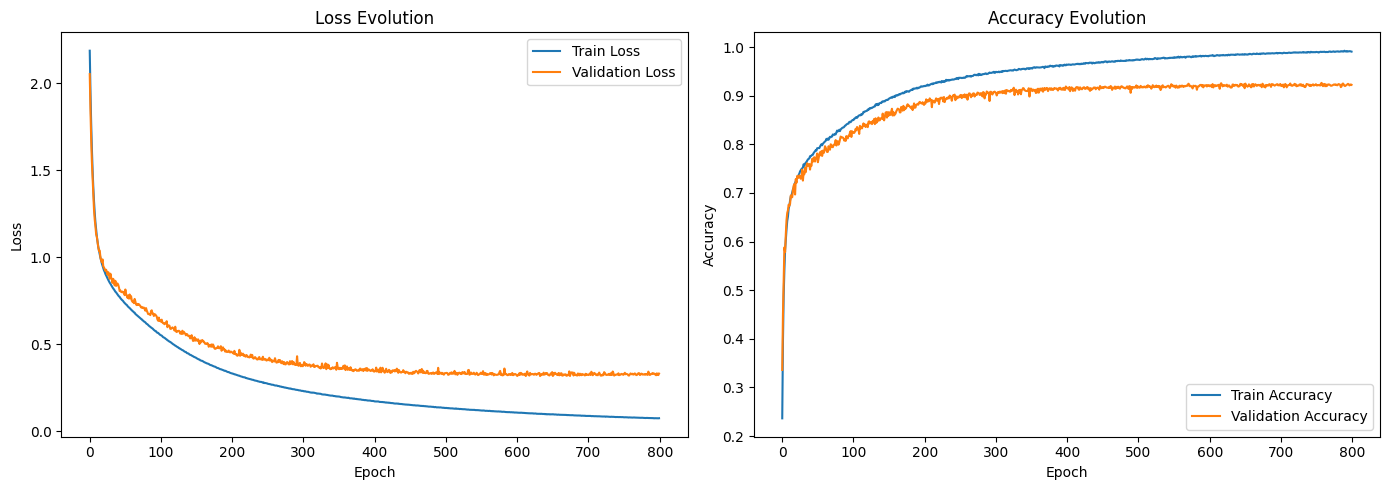

587/587 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step

---- Train Set Analysis ----
Accuracy: 0.9921125559582179, F1 Score: 0.9921092586873744

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1897
           1       0.99      0.99      0.99      1854
           2       0.99      0.99      0.99      1879
           3       1.00      0.98      0.99      1853
           4       0.99      0.99      0.99      1882
           5       0.99      0.99      0.99      1897
           6       0.99      0.99      0.99      1899
           7       0.99      1.00      0.99      1865
           8       0.99      1.00      0.99      1909
           9       0.99      1.00      1.00      1829

    accuracy                           0.99     18764
   macro avg       0.99      0.99      0.99     18764
weighted avg       0.99      0.99      0.99     18764


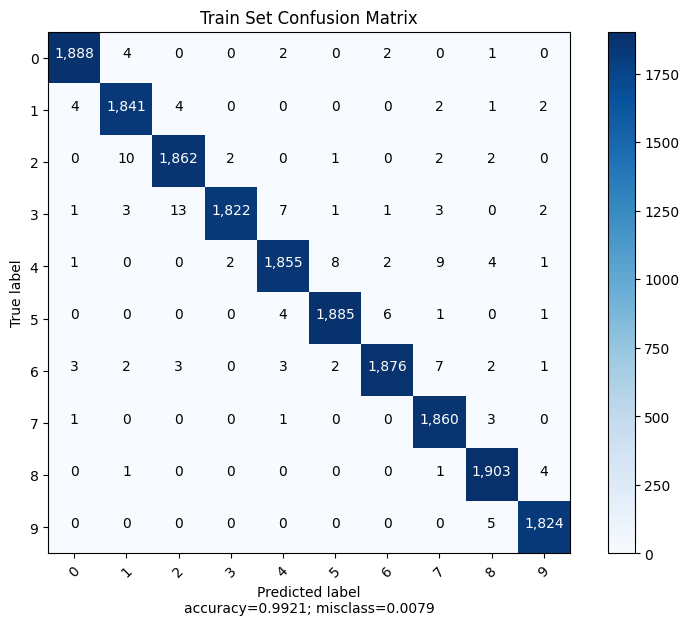


---- Test Set Analysis ----
Accuracy: 0.9266351653817458, F1 Score: 0.9267268571270962

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       382
           1       0.94      0.94      0.94       449
           2       0.90      0.94      0.92       411
           3       0.98      0.92      0.95       413
           4       0.89      0.89      0.89       413
           5       0.95      0.92      0.94       364
           6       0.93      0.93      0.93       402
           7       0.92      0.89      0.90       387
           8       0.90      0.93      0.91       398
           9       0.92      0.94      0.93       402

    accuracy                           0.93      4021
   macro avg       0.93      0.93      0.93      4021
weighted avg       0.93      0.93      0.93      4021



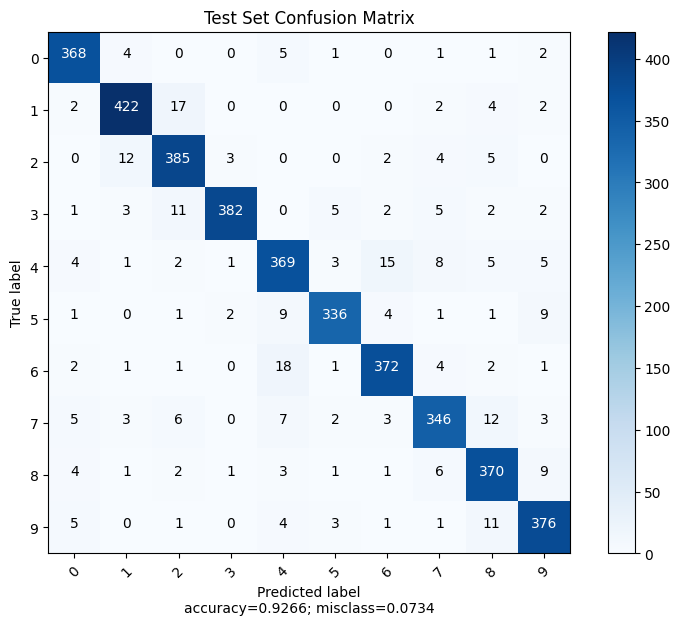


---- Validation Set Analysis ----
Accuracy: 0.9224073613528972, F1 Score: 0.9224328943436552

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       386
           1       0.94      0.95      0.94       375
           2       0.92      0.91      0.91       388
           3       0.97      0.92      0.95       412
           4       0.88      0.88      0.88       396
           5       0.96      0.94      0.95       430
           6       0.91      0.89      0.90       390
           7       0.93      0.92      0.93       426
           8       0.89      0.91      0.90       397
           9       0.92      0.93      0.93       421

    accuracy                           0.92      4021
   macro avg       0.92      0.92      0.92      4021
weighted avg       0.92      0.92      0.92      4021



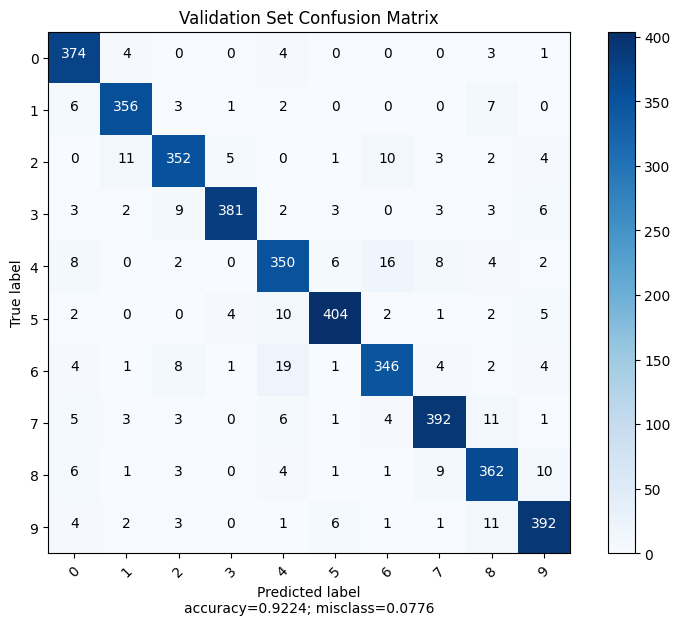

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

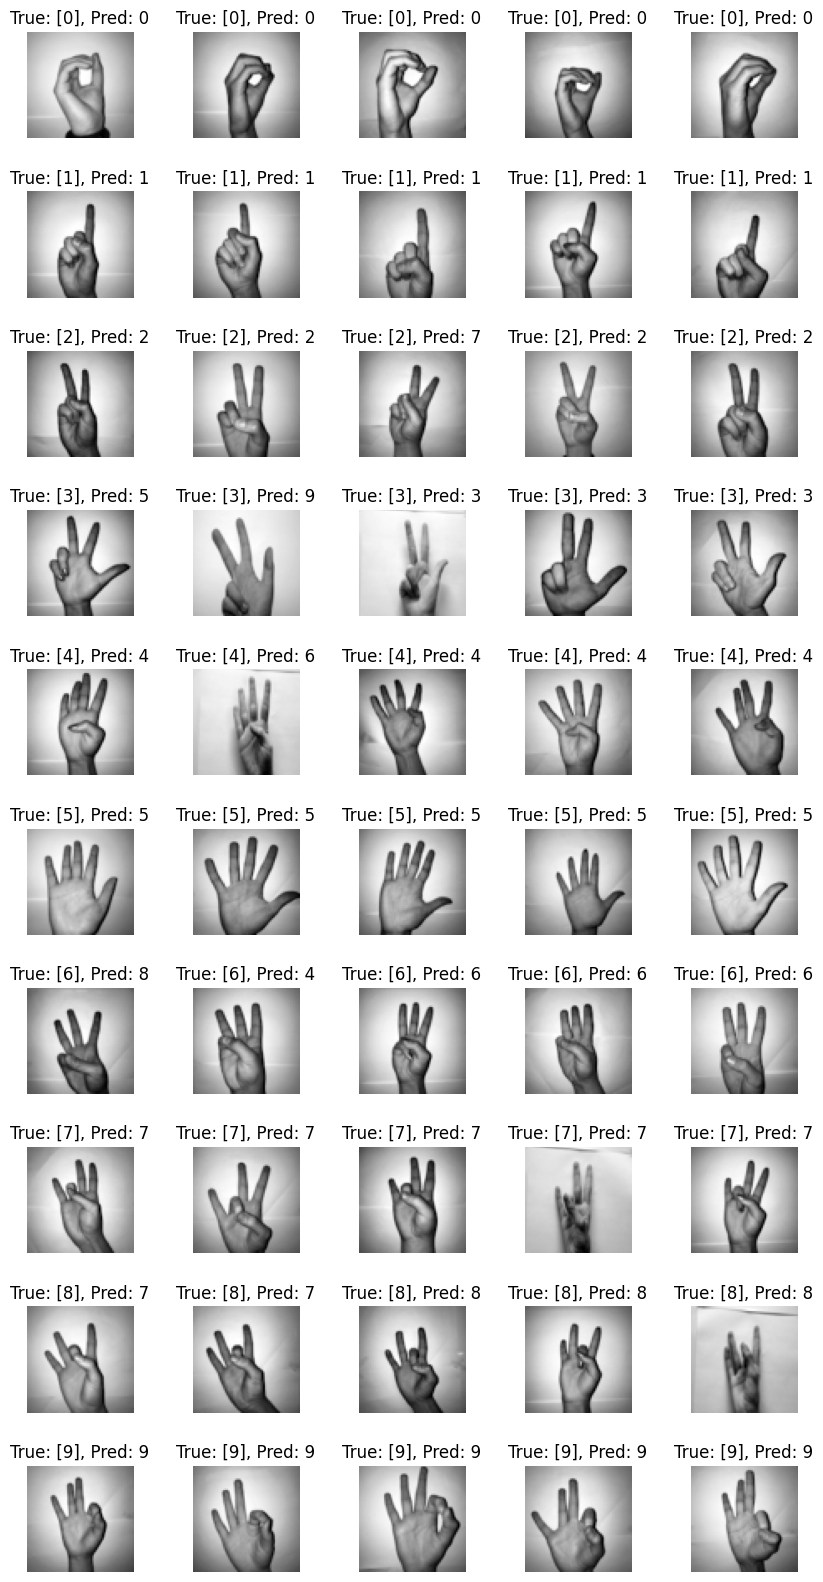

In [48]:
trained_model_augmented, encoder_augmented = hyperparameter_tuning_test(X_train_augmented, Y_train_augmented, X_test_augmented, Y_test_augmented, X_val_augmented, Y_val_augmented)

random_images_augmented = []

for i in range(10):  # Assumindo 10 classes
    random_images_augmented.append(np.where(Y_augmented == i)[0][0:5])

random_images_augmented = np.array(random_images_augmented).flatten()

# Plot the images with predictions
fig, axes = plt.subplots(10, 5, figsize=(10, 20))  # Ajustar o tamanho conforme necessário

for idx, image_idx in enumerate(random_images_augmented):
    i, j = divmod(idx, 5)
    
    axes[i, j].imshow(X_augmented[image_idx], cmap='gray')  # Ajuste aqui se X_original não é a variável correta
    axes[i, j].axis('off')
    
    # Preparar a imagem para predição (certifique-se de que está no formato correto esperado pelo modelo)
    image_prepared = X_augmented_flatten[image_idx].reshape(1, -1)  # Ajustar conforme o formato esperado pelo modelo
    
    # Fazer a predição
    pred_prob = trained_model.predict(image_prepared)
    pred_class = np.argmax(pred_prob, axis=-1)
    
    # Utilize o encoder para transformar a previsão de volta para o label original
    pred_label = encoder.inverse_transform(pred_class)[0]
    
    true_label = Y_augmented[image_idx]
    axes[i, j].set_title(f'True: {true_label}, Pred: {pred_label}')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()